In [ ]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from google.colab import files

# Loading the data set
mnist_train = datasets.MNIST("../data",
                             train=True,
                             download=True,
                             transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data",
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size=500, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=500, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)

# Training the model

In [ ]:
def epoch(loader, model, opt=None):
    """Run standard train/eval epoch over the dataset.

    Args:
        loader: This should be either the train_loader or test_loader
        model: This should be model_cnn or model_cnn_robust
        opt: Optimizer (e.g., an instance of optim.SGD())
    """
    total_loss, total_err = 0., 0.
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp, y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

def train(model):
  optimizer = optim.SGD(model.parameters(), lr=1e-1)
  print(*("{:<24}".format(i) for i in (
        'Train Acc (Standard)', 'Test Acc (Standard)'
        )))
  # initially number of epochs was 10
  for t in range(5):
      train_err, train_loss = epoch(train_loader, model, optimizer)
      test_err, test_loss = epoch(test_loader, model)
      train_acc = 100 - train_err * 100
      test_acc = 100 - test_err * 100
      if t == 4:
          for param_group in optimizer.param_groups:
              param_group["lr"] = 1e-2
      print(*("{:<24.6f}".format(i) for i in (train_acc, test_acc)))

# Evaluating Adversarial Robustness (FGSM)

In [ ]:
def fgsm(model, X, y, epsilon=0.1):
    """Construct adversarial attack using Fast Gradient Sign Method (FGSM).

    Args:
      model: NN model, such as model_cnn or model_cnn_robust defined below
      X: Features
      y: Labels
      epsilon: L_infinity norm of perturbation

    Returns:
      Perturbation (delta), of the same size as X, such that the adversarial
      examples can be constructed as X + delta.
    """
    # TODO: Change this code to output the correct perturbation.
    # delta = torch.zeros_like(X)
    X.requires_grad = True
    yp = model(X)
    loss = nn.CrossEntropyLoss()(yp, y)
    loss.backward(retain_graph=True)
    gradient = X.grad
    # delta = epsilon * torch.sign(torch.autograd.grad(loss, X))
    delta = epsilon * torch.sign(gradient)
    return delta

def epoch_adversarial(loader, model, attack=fgsm, opt=None):
    """Run adversarial train/eval epoch over the dataset.

    If opt is not provided, then this simply computes the adversarial error 
    and loss.  If opt is provided, then an optimization step is also performed.

    Args:
        loader: This should be either the train_loader or test_loader
        model: This should be model_cnn or model_cnn_robust
        opt: Optimizer (e.g., an instance of optim.SGD()).
    Returns:
      The average (adversarial) error and loss.
    """
    # TODO: Change the code below to use the adversarial loss.
    total_loss, total_err = 0., 0.
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        yp = model(X.add(attack(model_cnn, X, y)))
        loss = nn.CrossEntropyLoss()(yp, y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    adv_err = total_err / len(loader.dataset)
    adv_acc = 100 - adv_err * 100
    return adv_acc, total_loss / len(loader.dataset)

def plot_images(X, y, yp, M=2, N=3):
    _, ax = plt.subplots(M, N, sharex=True, sharey=True, figsize=(N, M * 1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1 - X[i * N + j][0].cpu().numpy(), cmap="gray")
            if yp is not None:
                title = ax[i][j].set_title("Pred: {}".format(yp[i * N +
                                                            j].max(dim=0)[1]))
            if yp is not None:
                plt.setp(title,
                     color=('g' if yp[i * N + j].max(
                         dim=0)[1] == y[i * N + j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()


def visualize_adversarial(model, attack=fgsm):
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        break
    yp = model(X)
    plot_images(X, y, yp)

    # TODO: Construct adversarial examples, and visualize with the plot_images function.
    delta = attack(model, X, y)
    X_copy = X.detach()
    adversarial_X = X_copy.add(delta)
    yp = model(adversarial_X)
    plot_images(adversarial_X, y, yp)
    plt.show()

### PGD

In [ ]:
def projected_gradient_descent(epsilon=0.1):
    def projected_gradient_descent_curry(model, x, y, num_steps=50, #step_size=0.06, 
                                  step_norm='inf', epsilon=epsilon, eps_norm='inf',
                                  clamp=(0,1)):
        """Performs the projected gradient descent attack on a batch of images."""
        x_adv = x.clone().detach().requires_grad_(True).to(x.device)
        num_channels = x.shape[1]
        eps = epsilon
        step_size = eps/20

        for i in range(num_steps):
            _x_adv = x_adv.clone().detach().requires_grad_(True)

            prediction = model(_x_adv)
            loss = nn.CrossEntropyLoss()(prediction, y)
            loss.backward()
            
            with torch.no_grad():
                gradients = _x_adv.grad.sign() * step_size
                x_adv += gradients
                # projecting back into the L-infty ball
                x_adv = torch.max(torch.min(x_adv, x + eps), x - eps)

        delta = x_adv - x
        return delta.detach()
    return projected_gradient_descent_curry

def test_pgd(model, eps_set=[0.01, 0.03, 0.1, 0.3, 1, 3]):
    for epsilon in eps_set:
        print(f"Adversarial accuracy (PGD): epsilon = {epsilon}")
        print(epoch_adversarial(test_loader, model, attack=projected_gradient_descent(epsilon))[0])
        visualize_adversarial(model, attack=projected_gradient_descent(epsilon))

## Convolutional Neural Networks

In [ ]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

## Baseline model : CNN on raw data.
model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
						  nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
						  nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
						  nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
						  Flatten(), nn.Linear(7 * 7 * 64, 100), nn.ReLU(),
						  nn.Linear(100, 10)).to(device)
				
# train(model_cnn)

In [ ]:
# torch.save(model_cnn.state_dict(), 'model_cnn.pth')
state_dict = torch.load('model_cnn.pth')
print(state_dict.keys())
model_cnn.load_state_dict(state_dict)

odict_keys(['0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias', '6.weight', '6.bias', '9.weight', '9.bias', '11.weight', '11.bias'])


<All keys matched successfully>

Adversarial accuracy (PGD): epsilon = 0.01
96.12


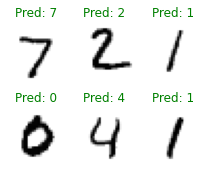

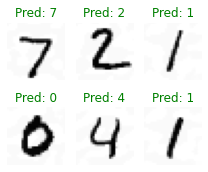

Adversarial accuracy (PGD): epsilon = 0.03
89.44


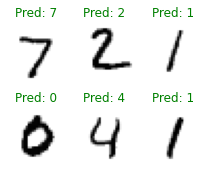

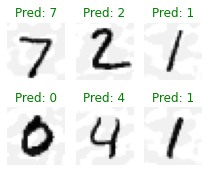

Adversarial accuracy (PGD): epsilon = 0.1
24.379999999999995


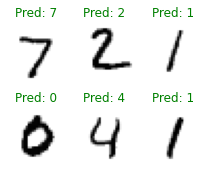

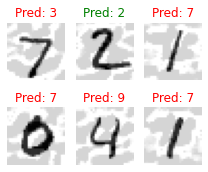

Adversarial accuracy (PGD): epsilon = 0.3
0.0


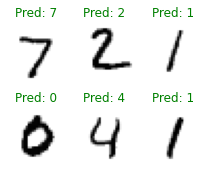

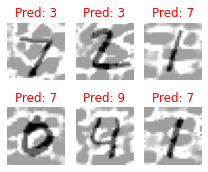

Adversarial accuracy (PGD): epsilon = 1
0.0


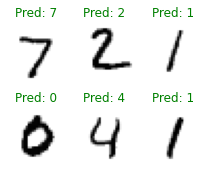

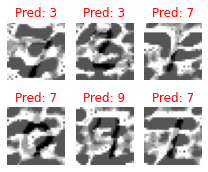

Adversarial accuracy (PGD): epsilon = 3
0.0


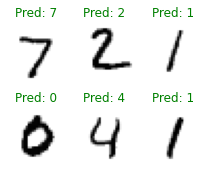

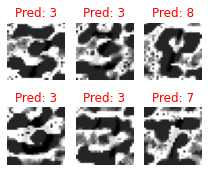

In [ ]:
# print("Adversarial accuracy - CNN model - FGSM")
# print(epoch_adversarial(test_loader, model_cnn)[0])
# visualize_adversarial(model_cnn)
test_pgd(model_cnn)

Adversarial error - CNN model - PGD
22.150000000000006


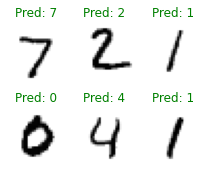

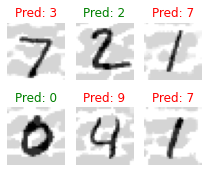

In [ ]:
# print("Adversarial error - CNN model - PGD")
# print(epoch_adversarial(test_loader, model_cnn, attack=projected_gradient_descent)[0])
# visualize_adversarial(model_cnn, attack=projected_gradient_descent)

Adversarial error - CNN model - PGD -- 0.01
95.67


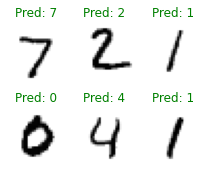

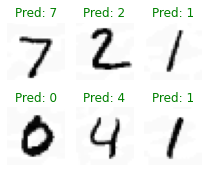

Adversarial error - CNN model - PGD -- 0.03
87.77


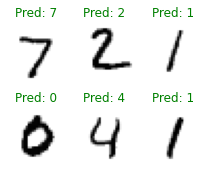

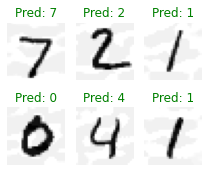

Adversarial error - CNN model - PGD -- 0.1
22.83


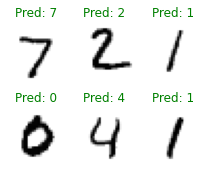

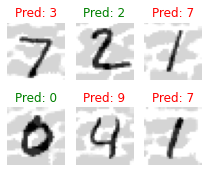

Adversarial error - CNN model - PGD -- 0.3
0.0


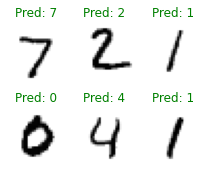

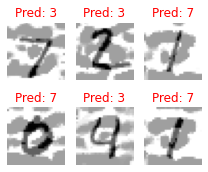

Adversarial error - CNN model - PGD -- 1


## Fully connected linear network

In [ ]:
## Fully connected two layer network on raw data.
model_fcn = nn.Sequential(Flatten(), 
                          nn.Linear(28*28, 100), nn.ReLU(), 
                          nn.Linear(100, 100), nn.ReLU(),
						              nn.Linear(100, 10)).to(device)
                    
train(model_fcn)
# torch.save(model_fcn.state_dict(), 'model_fcn.pth')

# state_dict = torch.load('model_fcn.pth')
# print(state_dict.keys())
# model_fcn.load_state_dict(state_dict)

Train Acc (Standard)     Test Acc (Standard)     
58.313333                81.850000               
86.243333                88.990000               
89.373333                90.600000               
90.691667                91.360000               
91.510000                92.260000               


Adversarial accuracy (PGD): epsilon = 0.01
90.69


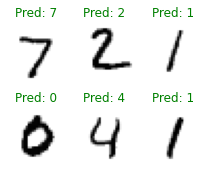

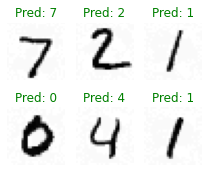

Adversarial accuracy (PGD): epsilon = 0.03
86.51


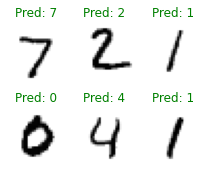

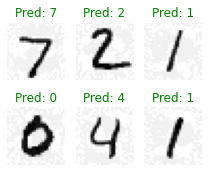

Adversarial accuracy (PGD): epsilon = 0.1
58.08


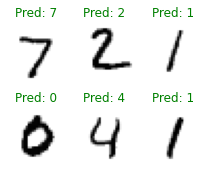

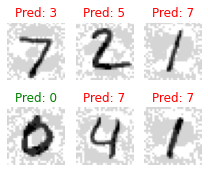

Adversarial accuracy (PGD): epsilon = 0.3
3.049999999999997


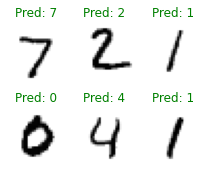

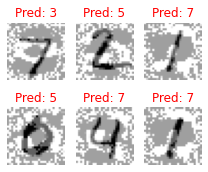

Adversarial accuracy (PGD): epsilon = 1
0.0


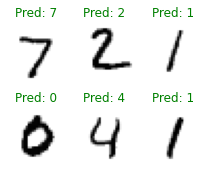

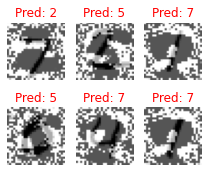

Adversarial accuracy (PGD): epsilon = 3
0.0


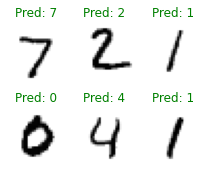

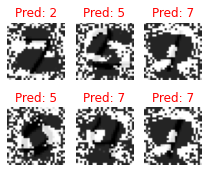

In [ ]:
# print("Adversarial error - FCN model - FGSM")
# print(epoch_adversarial(test_loader, model_fcn)[0])
# visualize_adversarial(model_fcn)

# print("Adversarial error - FCN model - PGD")
# print(epoch_adversarial(test_loader, model_fcn, attack=projected_gradient_descent)[0])
# visualize_adversarial(model_fcn, attack=projected_gradient_descent)
test_pgd(model_fcn)

Adversarial error - FCN model - FGSM
91.96000000000001


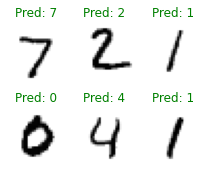

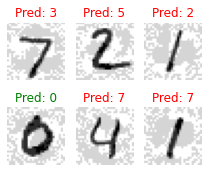

In [ ]:
# test_err, test_loss = epoch(test_loader, model_fcn)
# # train_acc = 100 - train_err * 100
# test_acc = 100 - test_err * 100
# print(test_acc)

print("Adversarial error - FCN model - FGSM")
print(epoch_adversarial(test_loader, model_fcn)[0])
visualize_adversarial(model_fcn)

## Computing the PCA matrices

<class 'torch.Tensor'> torch.Size([60000, 784])


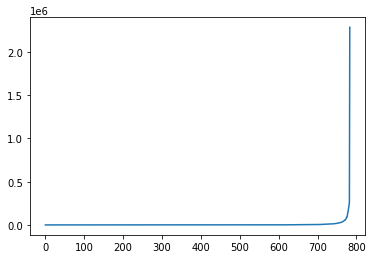

False


In [ ]:
train_size = 60000
pca_data_loader = DataLoader(mnist_train, batch_size=train_size, shuffle=True)

import numpy as np
from sklearn import decomposition
pca = decomposition.PCA()

for X, y in pca_data_loader:
  X = np.reshape(X, [train_size, -1])
  print(type(X), X.size())
  X = torch.transpose(X, 0, 1)
  C = torch.matmul(X, torch.transpose(X, 0, 1))
  eigenvalues, eigenvectors = torch.linalg.eigh(C)
  plt.plot(eigenvalues)
  plt.show()
  break

np.save('eigenvectors.npy', eigenvectors)
eigenvectors_2 = np.load('eigenvectors.npy')
print(np.all(eigenvectors_2 == eigenvectors))

In [ ]:
k = 10
Uk = eigenvectors[:, 784-k:]
print(Uk.size())
Uk=Uk.to(device)

torch.Size([784, 10])


## PCA 1
Input has dimension $k$

In [ ]:
class pca_layer_1(nn.Module):
    def forward(self, x):
        return torch.matmul(x, Uk)
        
## Fully connected two layer network on raw data.
model_pca_1 = nn.Sequential(Flatten(), pca_layer_1(),
                          nn.Linear(k, 100), nn.ReLU(), 
                          nn.Linear(100, 100), nn.ReLU(),
						              nn.Linear(100, 10)).to(device)
                    
train(model_pca_1)
torch.save(model_pca_1.state_dict(), f'model_pca_1_{k}.pth')
# state_dict = torch.load('model_pca_1.pth')
# model_pca_1.load_state_dict(state_dict)


Train Err (Standard)     Test Err (Standard)     
0.288150                 0.193500                
0.187400                 0.177300                
0.164083                 0.145700                
0.142367                 0.130800                
0.129883                 0.119600                


Adversarial error - PCA 1 model - FGSM
0.3047


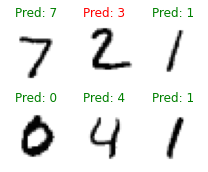

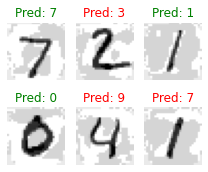

Adversarial error - PCA 1 model - PGD
0.3063


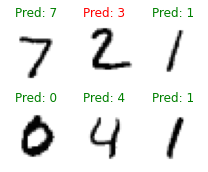

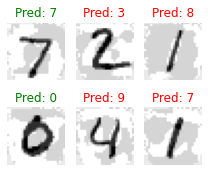

In [ ]:
print("Adversarial error - PCA 1 model - FGSM")
print(epoch_adversarial(test_loader, model_pca_1)[0])
visualize_adversarial(model_pca_1)

print("Adversarial error - PCA 1 model - PGD")
print(epoch_adversarial(test_loader, model_pca_1, attack=projected_gradient_descent)[0])
visualize_adversarial(model_pca_1, attack=projected_gradient_descent)

# PCA 2
Input has dimension $784$

In [ ]:
class pca_layer_2(nn.Module):
    def forward(self, x):
        return torch.matmul(torch.matmul(x, Uk), torch.transpose(Uk, 0, 1))
        
## Fully connected two layer network on raw data.
model_pca_2 = nn.Sequential(Flatten(), pca_layer_2(),
                          nn.Linear(784, 100), nn.ReLU(), 
                          nn.Linear(100, 100), nn.ReLU(),
						              nn.Linear(100, 10)).to(device)
                    
train(model_pca_2)
torch.save(model_pca_2.state_dict(), 'model_pca_2.pth')
# state_dict = torch.load('model_pca_2.pth')
# print(state_dict.keys())
# model_pca_2.load_state_dict(state_dict)

Train Err (Standard)     Test Err (Standard)     
0.378567                 0.178400                
0.138167                 0.108300                
0.104700                 0.093700                
0.093050                 0.085700                
0.083933                 0.076600                


Adversarial error - PCA 2 model - FGSM
0.3725


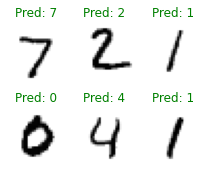

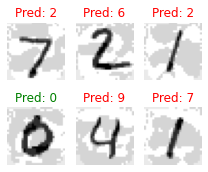

Adversarial error - PCA 2 model - PGD
0.1418


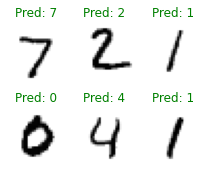

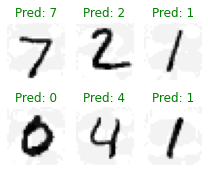

In [ ]:
print("Adversarial error - PCA 2 model - FGSM")
print(epoch_adversarial(test_loader, model_pca_2)[0])
visualize_adversarial(model_pca_2)

print("Adversarial error - PCA 2 model - PGD")
print(epoch_adversarial(test_loader, model_pca_2, attack=projected_gradient_descent)[0])
visualize_adversarial(model_pca_2, attack=projected_gradient_descent)

# For Loop!

PCA with k = 5
------------------------
------------------------

torch.Size([784, 5])
Train Acc (Standard)     Test Acc (Standard)     
60.220000                68.130000               
66.295000                70.020000               
68.876667                70.910000               
70.006667                72.070000               
70.938333                72.290000               
Adversarial accuracy (PGD): epsilon = 0.01
71.19


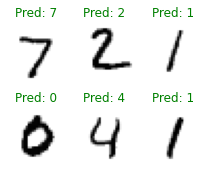

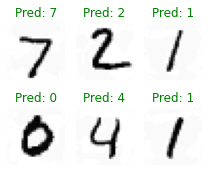

Adversarial accuracy (PGD): epsilon = 0.03
68.35


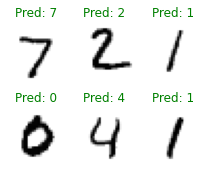

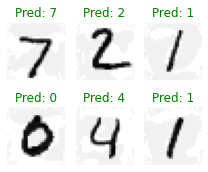

Adversarial accuracy (PGD): epsilon = 0.1
55.64


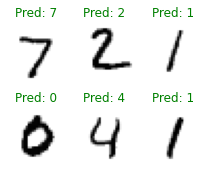

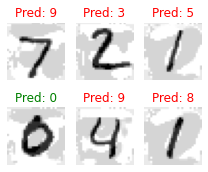

Adversarial accuracy (PGD): epsilon = 0.3
19.370000000000005


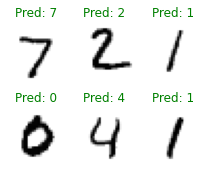

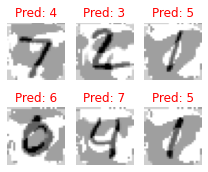

Adversarial accuracy (PGD): epsilon = 1
2.6599999999999966


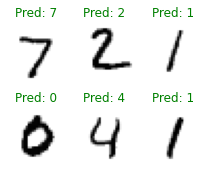

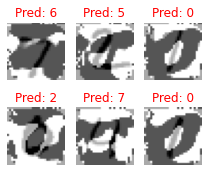

Adversarial accuracy (PGD): epsilon = 3
0.9200000000000017


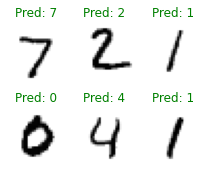

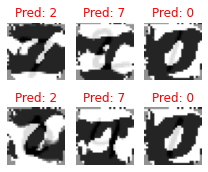

PCA with k = 10
------------------------
------------------------

torch.Size([784, 10])
Train Acc (Standard)     Test Acc (Standard)     
71.845000                78.760000               
80.936667                82.560000               
83.215000                84.870000               
85.390000                87.220000               
86.776667                88.010000               
Adversarial accuracy (PGD): epsilon = 0.01
86.88


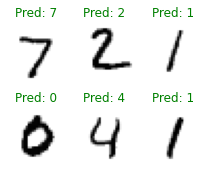

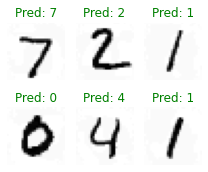

Adversarial accuracy (PGD): epsilon = 0.03
83.92


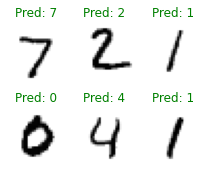

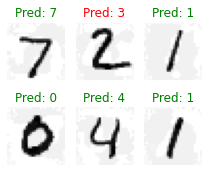

Adversarial accuracy (PGD): epsilon = 0.1
69.25999999999999


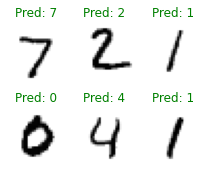

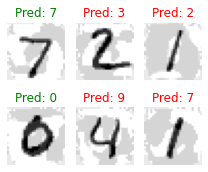

Adversarial accuracy (PGD): epsilon = 0.3
17.849999999999994


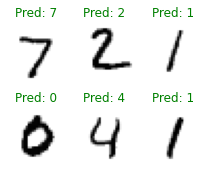

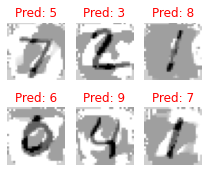

Adversarial accuracy (PGD): epsilon = 1
0.14999999999999147


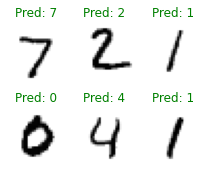

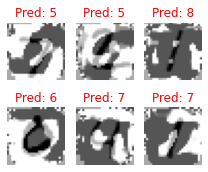

Adversarial accuracy (PGD): epsilon = 3
0.0


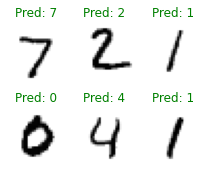

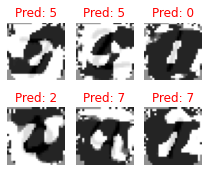

PCA with k = 30
------------------------
------------------------

torch.Size([784, 30])
Train Acc (Standard)     Test Acc (Standard)     
70.603333                85.520000               
87.235000                88.840000               
89.196667                90.050000               
90.336667                91.150000               
91.135000                91.560000               
Adversarial accuracy (PGD): epsilon = 0.01
90.46000000000001


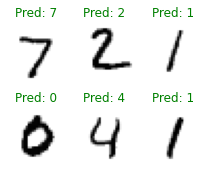

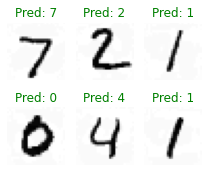

Adversarial accuracy (PGD): epsilon = 0.03
87.36


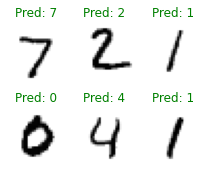

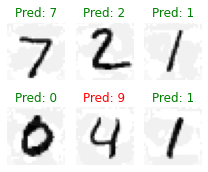

Adversarial accuracy (PGD): epsilon = 0.1
67.06


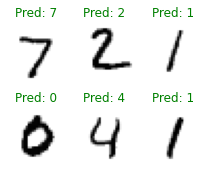

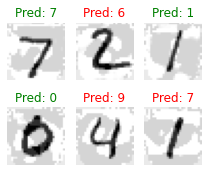

Adversarial accuracy (PGD): epsilon = 0.3
7.670000000000002


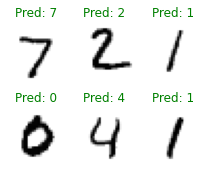

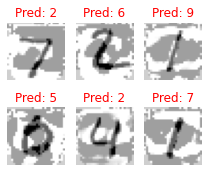

Adversarial accuracy (PGD): epsilon = 1
0.010000000000005116


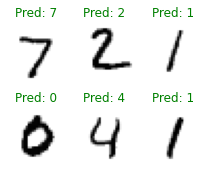

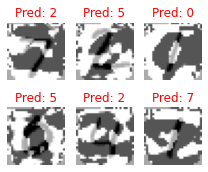

Adversarial accuracy (PGD): epsilon = 3
0.0


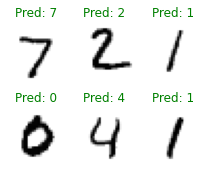

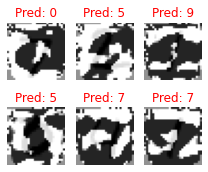

PCA with k = 50
------------------------
------------------------

torch.Size([784, 50])
Train Acc (Standard)     Test Acc (Standard)     
70.100000                86.870000               
87.858333                89.840000               
89.866667                90.900000               
90.786667                91.890000               
91.600000                92.340000               
Adversarial accuracy (PGD): epsilon = 0.01
91.01


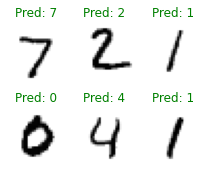

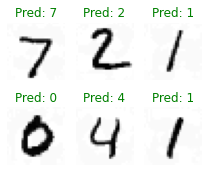

Adversarial accuracy (PGD): epsilon = 0.03
87.41


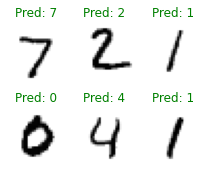

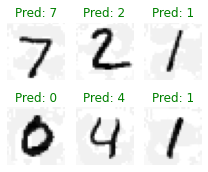

Adversarial accuracy (PGD): epsilon = 0.1
64.31


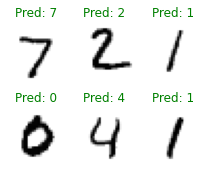

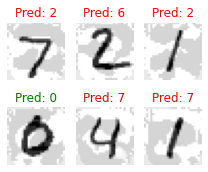

Adversarial accuracy (PGD): epsilon = 0.3
5.650000000000006


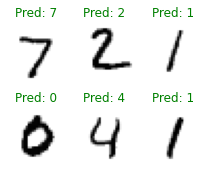

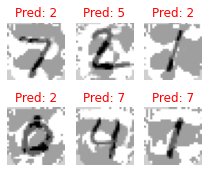

Adversarial accuracy (PGD): epsilon = 1
0.0


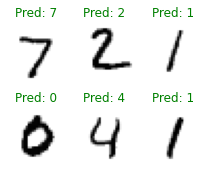

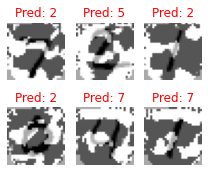

Adversarial accuracy (PGD): epsilon = 3
0.0


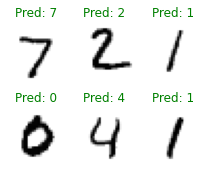

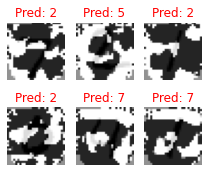

PCA with k = 70
------------------------
------------------------

torch.Size([784, 70])
Train Acc (Standard)     Test Acc (Standard)     
66.856667                85.400000               
87.540000                89.760000               
90.021667                90.950000               
90.998333                91.900000               
91.785000                92.720000               
Adversarial accuracy (PGD): epsilon = 0.01
91.14


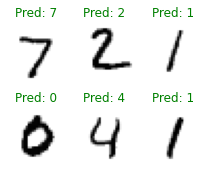

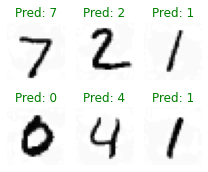

Adversarial accuracy (PGD): epsilon = 0.03
87.53999999999999


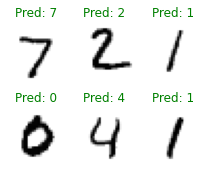

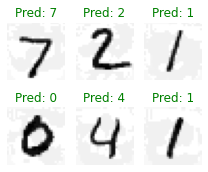

Adversarial accuracy (PGD): epsilon = 0.1
63.72


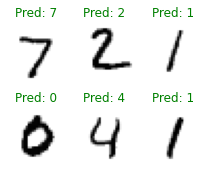

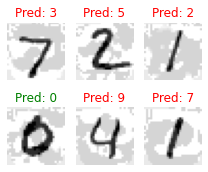

Adversarial accuracy (PGD): epsilon = 0.3
5.540000000000006


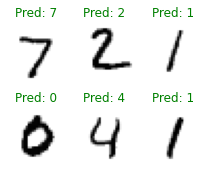

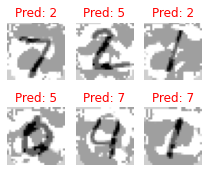

Adversarial accuracy (PGD): epsilon = 1
0.0


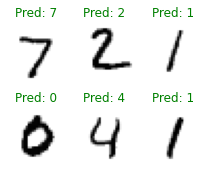

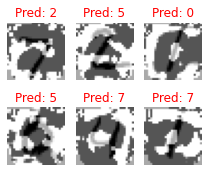

Adversarial accuracy (PGD): epsilon = 3
0.0


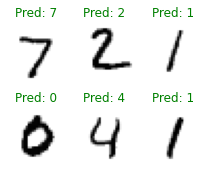

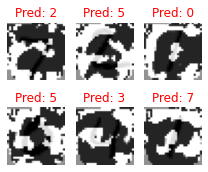

PCA with k = 100
------------------------
------------------------

torch.Size([784, 100])
Train Acc (Standard)     Test Acc (Standard)     
67.581667                85.480000               
87.551667                89.610000               
89.993333                91.040000               
91.155000                92.100000               
91.915000                92.660000               
Adversarial accuracy (PGD): epsilon = 0.01
91.14


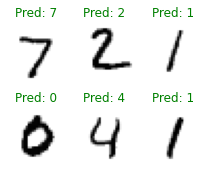

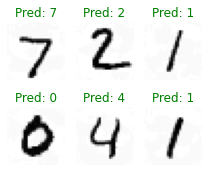

Adversarial accuracy (PGD): epsilon = 0.03
87.35


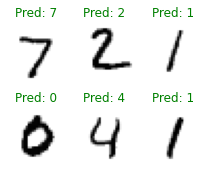

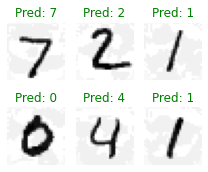

Adversarial accuracy (PGD): epsilon = 0.1
62.97


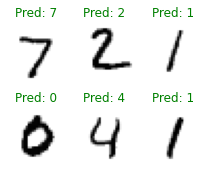

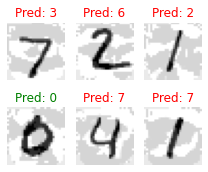

Adversarial accuracy (PGD): epsilon = 0.3
4.179999999999993


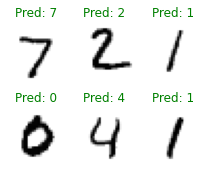

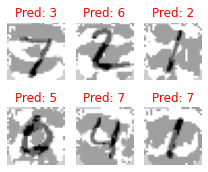

Adversarial accuracy (PGD): epsilon = 1
0.010000000000005116


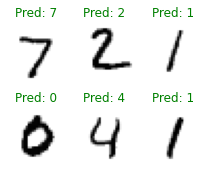

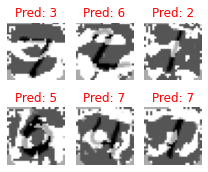

Adversarial accuracy (PGD): epsilon = 3
0.0


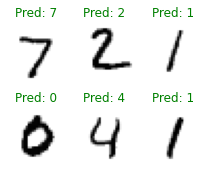

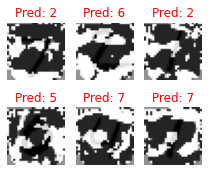

PCA with k = 200
------------------------
------------------------

torch.Size([784, 200])
Train Acc (Standard)     Test Acc (Standard)     
62.533333                85.690000               
87.338333                89.410000               
89.691667                90.810000               
90.750000                91.600000               
91.515000                92.320000               
Adversarial accuracy (PGD): epsilon = 0.01
90.69


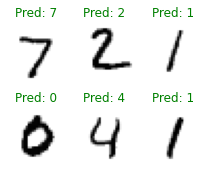

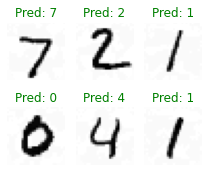

Adversarial accuracy (PGD): epsilon = 0.03
86.92


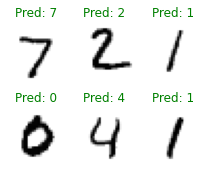

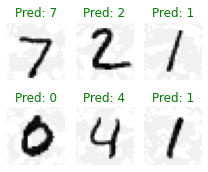

Adversarial accuracy (PGD): epsilon = 0.1
59.73


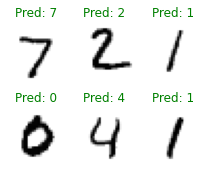

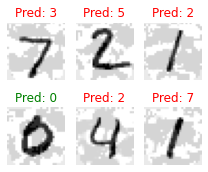

Adversarial accuracy (PGD): epsilon = 0.3
3.700000000000003


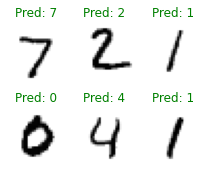

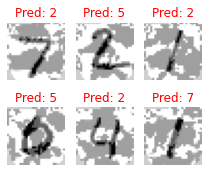

Adversarial accuracy (PGD): epsilon = 1
0.0


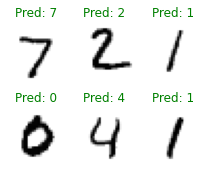

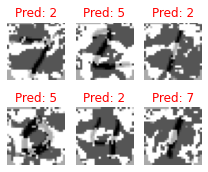

Adversarial accuracy (PGD): epsilon = 3
0.0


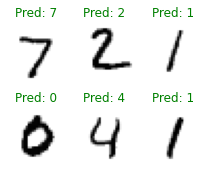

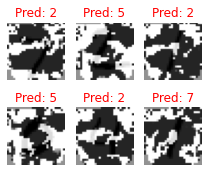

PCA with k = 300
------------------------
------------------------

torch.Size([784, 300])
Train Acc (Standard)     Test Acc (Standard)     
63.610000                85.620000               
86.993333                88.990000               
89.650000                90.670000               
90.736667                91.820000               
91.495000                92.010000               
Adversarial accuracy (PGD): epsilon = 0.01
90.39


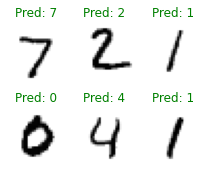

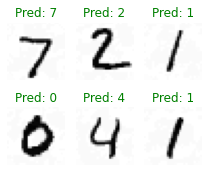

Adversarial accuracy (PGD): epsilon = 0.03
86.2


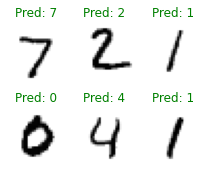

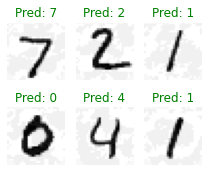

Adversarial accuracy (PGD): epsilon = 0.1
59.12


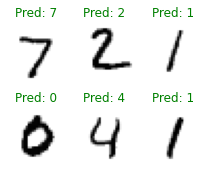

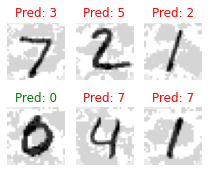

Adversarial accuracy (PGD): epsilon = 0.3
3.739999999999995


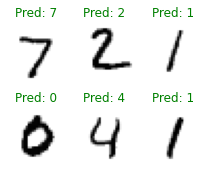

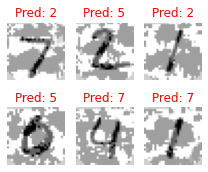

Adversarial accuracy (PGD): epsilon = 1
0.0


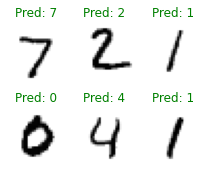

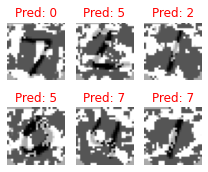

Adversarial accuracy (PGD): epsilon = 3
0.0


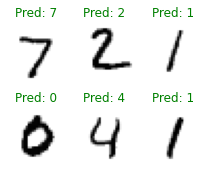

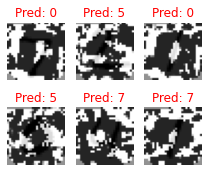

In [ ]:
# k_list = [3, 5, 10, 20, 30, 40, 50, 100, 200, 300, 500, 600, 784]
k_list = [5, 10, 30, 50, 70, 100, 200, 300]

for k in k_list:
    print(f'PCA with k = {k}\n------------------------\n------------------------\n')

    Uk = eigenvectors[:, 784-k:]
    print(Uk.size())
    Uk=Uk.to(device)

    class pca_layer_1(nn.Module):
        def forward(self, x):
            return torch.matmul(x, Uk)
            
    ## Fully connected two layer network on raw data.
    model_pca_1 = nn.Sequential(Flatten(), pca_layer_1(),
                              nn.Linear(k, 100), nn.ReLU(), 
                              nn.Linear(100, 100), nn.ReLU(),
                              nn.Linear(100, 10)).to(device)
                        
    train(model_pca_1)
    torch.save(model_pca_1.state_dict(), f'model_pca_1_{k}.pth')
    test_pgd(model_pca_1)

    # class pca_layer_2(nn.Module):
    #     def forward(self, x):
    #         return torch.matmul(torch.matmul(x, Uk), torch.transpose(Uk, 0, 1))
            
    # ## Fully connected two layer network on raw data.
    # model_pca_2 = nn.Sequential(Flatten(), pca_layer_2(),
    #                           nn.Linear(784, 100), nn.ReLU(), 
    #                           nn.Linear(100, 100), nn.ReLU(),
    #                           nn.Linear(100, 10)).to(device)
                        
    # train(model_pca_2)
    # torch.save(model_pca_2.state_dict(), 'model_pca_2.pth')


k = 5
------------------------------
------------------------------

torch.Size([500, 1, 28, 28])
torch.Size([784, 5])
torch.Size([500, 1, 28, 28])


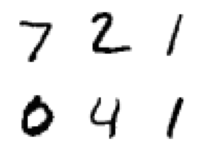

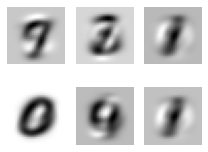

k = 10
------------------------------
------------------------------

torch.Size([500, 1, 28, 28])
torch.Size([784, 10])
torch.Size([500, 1, 28, 28])


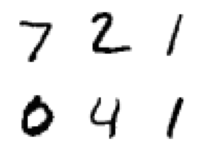

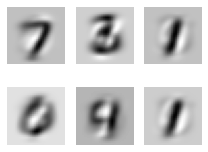

k = 30
------------------------------
------------------------------

torch.Size([500, 1, 28, 28])
torch.Size([784, 30])
torch.Size([500, 1, 28, 28])


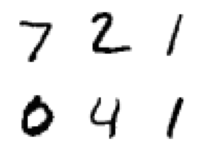

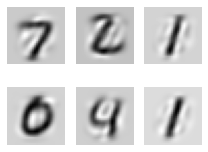

k = 50
------------------------------
------------------------------

torch.Size([500, 1, 28, 28])
torch.Size([784, 50])
torch.Size([500, 1, 28, 28])


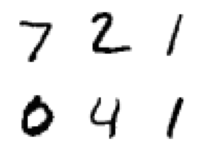

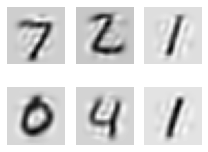

k = 70
------------------------------
------------------------------

torch.Size([500, 1, 28, 28])
torch.Size([784, 70])
torch.Size([500, 1, 28, 28])


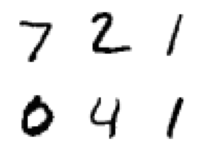

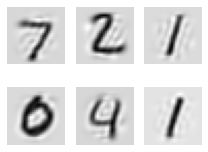

k = 100
------------------------------
------------------------------

torch.Size([500, 1, 28, 28])
torch.Size([784, 100])
torch.Size([500, 1, 28, 28])


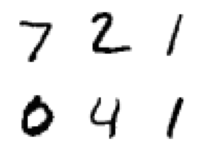

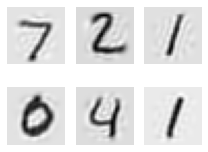

k = 200
------------------------------
------------------------------

torch.Size([500, 1, 28, 28])
torch.Size([784, 200])
torch.Size([500, 1, 28, 28])


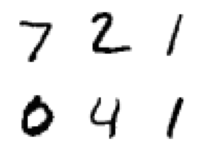

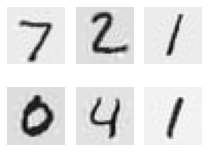

k = 300
------------------------------
------------------------------

torch.Size([500, 1, 28, 28])
torch.Size([784, 300])
torch.Size([500, 1, 28, 28])


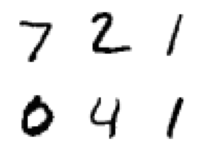

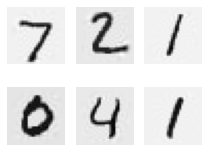

In [ ]:
k_list = [5, 10, 30, 50, 70, 100, 200, 300]
# k_list = []

def visualize_reconstructed(k):
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        break
    # yp = model(X)
    print(X.size())
    plot_images(X, y, None)

    Uk = eigenvectors[:, 784-k:]
    print(Uk.size())
    Uk = Uk.to(device)
    X = X.view(X.shape[0], -1)
    
    reconstructed_X = torch.matmul(torch.matmul(X, Uk), torch.transpose(Uk, 0, 1))
    reconstructed_X = reconstructed_X.reshape([-1, 1, 28, 28])

    print(reconstructed_X.size())

    # TODO: Construct adversarial examples, and visualize with the plot_images function.
    # delta = attack(model, X, y)
    # X_copy = X.detach()
    # adversarial_X = X_copy.add(delta)
    # yp = model(adversarial_X)
    plot_images(reconstructed_X, y, None)
    plt.show()

for k in k_list:
    print(f"k = {k}\n------------------------------\n------------------------------\n")
    visualize_reconstructed(k)